In [1]:
from utils import *
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3
from sklearn.neural_network import MLPRegressor as MLPR
from scipy import optimize
from scipy.stats import pearsonr, spearmanr

In [2]:
def g(ell, gp, mean_ntk, data):
    try:
        gp.set_params(**{'kernel__k2__length_scale': ell})
    except:
        gp.set_params(**{'kernel__k1__k2__length_scale': ell})

    gp.fit(data[0], data[1])
    mean = gp.predict(data[2])

    return np.sqrt(np.mean((mean_ntk - mean)**2))

In [3]:
noise = 0.15
X_init, y_init = make_friedman2(noise=noise, random_state=18397425)
datasets = processing(X_init, y_init)
X_orig, y_orig, X_train, y_train = [datasets['orig'][0], datasets['orig'][1], datasets['orig train'][0], datasets['orig train'][1]]
X_norm, X_norm_train = [datasets['norm'][0], datasets['norm train'][0]]
y_noisy_train = datasets['orig train'][2]

In [26]:
%%capture
depth = 3
alpha = 1e-5

data = (X_norm_train, y_train, X_norm)

ntk = (
    ConstantKernel(
        constant_value=1,
        constant_value_bounds=(1e-9, 1e5)
    ) *
    NTK(depth=3, c=2,
        bias=1e-1,
        bias_bounds=(1e-9, 1e3)
    ) 
    # + 
    # WhiteKernel(
    #     noise_level=1e-2, 
    #     noise_level_bounds=(1e-4, 1e1))
)

gp_ntk = GPR(kernel=ntk, alpha=alpha, normalize_y=True,
            n_restarts_optimizer=9, random_state=3480795)
gp_ntk.fit(data[0], data[1])
print(f'NTK {depth} : ', gp_ntk.kernel_)
mean_ntk = gp_ntk.predict(data[2])



lpk = (
    ConstantKernel(
        constant_value=gp_ntk.kernel_.get_params()['k1__constant_value'],
        constant_value_bounds='fixed'
    ) *
    Matern(
        nu=1/2,
        length_scale=0.1,
        length_scale_bounds='fixed'
    ) 
    # + 
    # WhiteKernel(
    #     noise_level=gp_ntk.kernel_.get_params()['k2__noise_level'], 
    #     noise_level_bounds='fixed')
)

gp_lpk = GPR(kernel=lpk, alpha=alpha, normalize_y=True,
                    n_restarts_optimizer=0, random_state=3480795)

ell_lpk = optimize.minimize_scalar(g, args=(
    gp_lpk, mean_ntk, data), 
    method='bounded', bounds=(1e-4, 1e-3), options={'maxiter': 10000})
for i in range(-2, 6):
    tmp = optimize.minimize_scalar(g, args=(
        gp_lpk, mean_ntk, data),
        method='bounded', bounds=(1e-4, 10**i), options={'maxiter': 10000})
    if tmp.fun < ell_lpk.fun:
        ell_lpk = tmp

try:
    gp_lpk.set_params(**{'kernel__k2__length_scale': ell_lpk.x})
except:
    gp_lpk.set_params(**{'kernel__k1__k2__length_scale': ell_lpk.x})
gp_lpk.fit(data[0], data[1])
mean_lpk_opt = gp_lpk.predict(data[2])



rbf = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e5)
    ) * 
    Matern(
        nu=np.inf,
        length_scale=0.1,
        length_scale_bounds='fixed'
    ) 
    # + 
    # WhiteKernel(
    #     noise_level=gp_ntk.kernel_.get_params()['k2__noise_level'],
    #     noise_level_bounds='fixed'
    # )
)

gp_rbf = GPR(kernel=rbf, alpha=alpha, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)

ell_rbf = optimize.minimize_scalar(g, args=(
    gp_rbf, mean_ntk, data), 
    method='bounded', bounds=(1e-4, 1e-3), options={'maxiter': 10000})
for i in range(-2, 6):
    tmp = optimize.minimize_scalar(g, args=(
        gp_rbf, mean_ntk, data),
        method='bounded', bounds=(1e-4, 10**i), options={'maxiter': 10000})
    if tmp.fun < ell_rbf.fun:
        ell_rbf = tmp

try:
    gp_rbf.set_params(**{'kernel__k2__length_scale': ell_rbf.x})
except:
    gp_rbf.set_params(**{'kernel__k1__k2__length_scale': ell_rbf.x})
gp_rbf.fit(data[0], data[1])
mean_rbf_opt = gp_rbf.predict(data[2])

In [30]:
%%capture
depth = 3
alpha = 1e-5

data = (X_norm_train, y_noisy_train, X_norm)

ntk = (
    ConstantKernel(
        constant_value=1,
        constant_value_bounds=(1e-9, 1e5)
    ) *
    NTK(depth=3, c=2,
        bias=1e-1,
        bias_bounds=(1e-9, 1e3)
    ) 
    + 
    WhiteKernel(
        noise_level=1e-2, 
        noise_level_bounds=(1e-4, 1e1))
)

gp_ntk = GPR(kernel=ntk, alpha=alpha, normalize_y=True,
            n_restarts_optimizer=9, random_state=3480795)
gp_ntk.fit(data[0], data[1])
print(f'NTK {depth} : ', gp_ntk.kernel_)
mean_ntk = gp_ntk.predict(data[2])



lpk = (
    ConstantKernel(
        constant_value=gp_ntk.kernel_.get_params()['k1__k1__constant_value'],
        constant_value_bounds='fixed'
    ) *
    Matern(
        nu=1/2,
        length_scale=0.1,
        length_scale_bounds='fixed'
    ) 
    + 
    WhiteKernel(
        noise_level=gp_ntk.kernel_.get_params()['k2__noise_level'], 
        noise_level_bounds='fixed')
)

gp_lpk = GPR(kernel=lpk, alpha=alpha, normalize_y=True,
                    n_restarts_optimizer=0, random_state=3480795)

ell_lpk = optimize.minimize_scalar(g, args=(
    gp_lpk, mean_ntk, data), 
    method='bounded', bounds=(1e-4, 1e-3), options={'maxiter': 10000})
for i in range(-2, 6):
    tmp = optimize.minimize_scalar(g, args=(
        gp_lpk, mean_ntk, data),
        method='bounded', bounds=(1e-4, 10**i), options={'maxiter': 10000})
    if tmp.fun < ell_lpk.fun:
        ell_lpk = tmp

try:
    gp_lpk.set_params(**{'kernel__k2__length_scale': ell_lpk.x})
except:
    gp_lpk.set_params(**{'kernel__k1__k2__length_scale': ell_lpk.x})
gp_lpk.fit(data[0], data[1])
mean_lpk_opt = gp_lpk.predict(data[2])



rbf = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e5)
    ) * 
    Matern(
        nu=np.inf,
        length_scale=0.1,
        length_scale_bounds='fixed'
    ) 
    + 
    WhiteKernel(
        noise_level=gp_ntk.kernel_.get_params()['k2__noise_level'],
        noise_level_bounds='fixed'
    )
)

gp_rbf = GPR(kernel=rbf, alpha=alpha, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)

ell_rbf = optimize.minimize_scalar(g, args=(
    gp_rbf, mean_ntk, data), 
    method='bounded', bounds=(1e-4, 1e-3), options={'maxiter': 10000})
for i in range(-2, 6):
    tmp = optimize.minimize_scalar(g, args=(
        gp_rbf, mean_ntk, data),
        method='bounded', bounds=(1e-4, 10**i), options={'maxiter': 10000})
    if tmp.fun < ell_rbf.fun:
        ell_rbf = tmp

try:
    gp_rbf.set_params(**{'kernel__k2__length_scale': ell_rbf.x})
except:
    gp_rbf.set_params(**{'kernel__k1__k2__length_scale': ell_rbf.x})
gp_rbf.fit(data[0], data[1])
mean_rbf_opt = gp_rbf.predict(data[2])

In [59]:
x1 = np.expand_dims(np.linspace(0, 100, 200), axis=1)
x2 = np.linspace(40*np.pi, 560*np.pi, 200)
x3 = np.linspace(0, 1, 200)
x4 = np.linspace(1, 11, 200)
means = np.array([100/2, (560 + 40)*np.pi/2, 0.5, 6])
means = np.expand_dims(means, axis=0)
means = np.repeat(means, 200, axis=0)
x1_data = np.hstack((x1, means[:,1:]))
x2_data = np.hstack((means[:,0], x2, means[:,2:]))
x3_data = np.hstack((means[:,0:2], x3, means[:,3:]))
x4_data = np.hstack((means[:,0:3], x4))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 2 has 2 dimension(s)

In [58]:
means[0,0:3]

array([5.00000000e+01, 9.42477796e+02, 5.00000000e-01])

In [27]:
print('Without Noise')
print('Lap corr :', np.corrcoef((mean_ntk)[:,0], (mean_lpk_opt)[:,0])[0, 1])
print('Lap rmse :', ell_lpk.fun)
print('Gaus corr:', np.corrcoef((mean_ntk)[:,0], (mean_rbf_opt)[:,0])[0, 1])
print('Gaus rmse:', ell_rbf.fun)
print(gp_ntk.kernel_)
print(gp_lpk.kernel_)
print(gp_rbf.kernel_)

No Noise
Lap corr : 0.9999999998489074
Lap rmse : 0.005905839322093592
Gaus corr: 0.9110312878898812
Gaus rmse: 138.33753814403585
18.3**2 * NTK(depth=3, c=2.000, bias=356.440)
18.3**2 * Matern(length_scale=1.45, nu=0.5)
1.44**2 * Matern(length_scale=0.00313, nu=inf)


In [31]:
print('With Noise')
print('Lap corr :', np.corrcoef((mean_ntk)[:,0], (mean_lpk_opt)[:,0])[0, 1])
print('Lap rmse :', ell_lpk.fun)
print('Gaus corr:', np.corrcoef((mean_ntk)[:,0], (mean_rbf_opt)[:,0])[0, 1])
print('Gaus rmse:', ell_rbf.fun)
print(gp_ntk.kernel_)
print(gp_lpk.kernel_)
print(gp_rbf.kernel_)

With Noise
Lap corr : 0.9996656804386628
Lap rmse : 3.8047971260821405
Gaus corr: 0.9890538985116736
Gaus rmse: 21.162874463611328
1.52**2 * NTK(depth=3, c=2.000, bias=0.000) + WhiteKernel(noise_level=0.741)
1.52**2 * Matern(length_scale=1.85, nu=0.5) + WhiteKernel(noise_level=0.741)
0.829**2 * Matern(length_scale=0.156, nu=inf) + WhiteKernel(noise_level=0.741)


Text(0.5, 0.98, 'Predictions without noise')

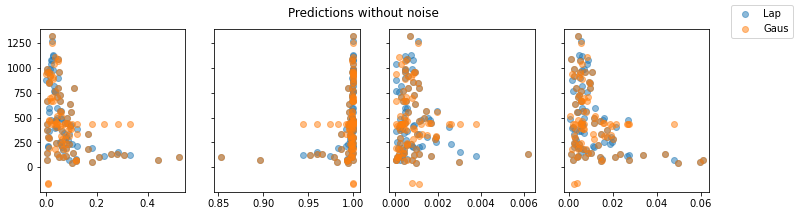

In [28]:
fig1, axes1 = plt.subplots(nrows=1, ncols=4, figsize=(12,3), sharey=True)
axes1 = axes1.ravel()

for i in range(0,3):
    axes1[i].scatter(X_norm[:,i], mean_lpk_opt, alpha=0.5)
    axes1[i].scatter(X_norm[:,i], mean_rbf_opt, alpha=0.5)
axes1[3].scatter(X_norm[:,3], mean_lpk_opt, alpha=0.5, label='Lap')
axes1[3].scatter(X_norm[:,3], mean_rbf_opt, alpha=0.5, label='Gaus')
fig1.legend()
fig1.suptitle('Predictions without noise')

Text(0.5, 0.98, 'Predictions with noise')

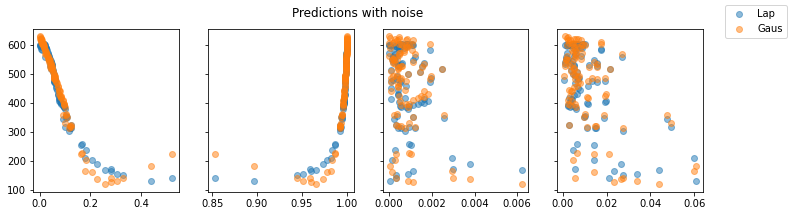

In [32]:
fig1, axes1 = plt.subplots(nrows=1, ncols=4, figsize=(12,3), sharey=True)
axes1 = axes1.ravel()

for i in range(0,3):
    axes1[i].scatter(X_norm[:,i], mean_lpk_opt, alpha=0.5)
    axes1[i].scatter(X_norm[:,i], mean_rbf_opt, alpha=0.5)
axes1[3].scatter(X_norm[:,3], mean_lpk_opt, alpha=0.5, label='Lap')
axes1[3].scatter(X_norm[:,3], mean_rbf_opt, alpha=0.5, label='Gaus')
fig1.legend()
fig1.suptitle('Predictions with noise')